In [1]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

Using TensorFlow backend.


Train on 1030 samples, validate on 258 samples
Epoch 1/100
1030/1030 [==============================] - 15s 14ms/step - loss: 1.5518 - acc: 0.5272 - val_loss: 0.6926 - val_acc: 0.4961

Epoch 00001: val_acc improved from -inf to 0.49612, saving model to weights.traint_100zoom_modelsimple_avec_crop.hdf5
Epoch 2/100
1030/1030 [==============================] - 1s 578us/step - loss: 0.6827 - acc: 0.5398 - val_loss: 0.6749 - val_acc: 0.5039

Epoch 00002: val_acc improved from 0.49612 to 0.50388, saving model to weights.traint_100zoom_modelsimple_avec_crop.hdf5
Epoch 3/100
1030/1030 [==============================] - 1s 583us/step - loss: 0.6674 - acc: 0.5835 - val_loss: 0.6129 - val_acc: 0.7248

Epoch 00003: val_acc improved from 0.50388 to 0.72481, saving model to weights.traint_100zoom_modelsimple_avec_crop.hdf5
Epoch 4/100
1030/1030 [==============================] - 1s 558us/step - loss: 0.6617 - acc: 0.6136 - val_loss: 0.6351 - val_acc: 0.6589

Epoch 00004: val_acc did not improve from


Epoch 00041: val_acc did not improve from 0.82946
Epoch 42/100
1030/1030 [==============================] - 1s 573us/step - loss: 0.4726 - acc: 0.7835 - val_loss: 0.4685 - val_acc: 0.7984

Epoch 00042: val_acc did not improve from 0.82946
Epoch 43/100
1030/1030 [==============================] - 1s 572us/step - loss: 0.4884 - acc: 0.7573 - val_loss: 0.4264 - val_acc: 0.8256

Epoch 00043: val_acc did not improve from 0.82946
Epoch 44/100
1030/1030 [==============================] - 1s 573us/step - loss: 0.5491 - acc: 0.7447 - val_loss: 0.6627 - val_acc: 0.5775

Epoch 00044: val_acc did not improve from 0.82946
Epoch 45/100
1030/1030 [==============================] - 1s 605us/step - loss: 0.5452 - acc: 0.7175 - val_loss: 0.4410 - val_acc: 0.8295

Epoch 00045: val_acc did not improve from 0.82946
Epoch 46/100
1030/1030 [==============================] - 1s 581us/step - loss: 0.4590 - acc: 0.7874 - val_loss: 0.7988 - val_acc: 0.5078

Epoch 00046: val_acc did not improve from 0.82946
Epoc

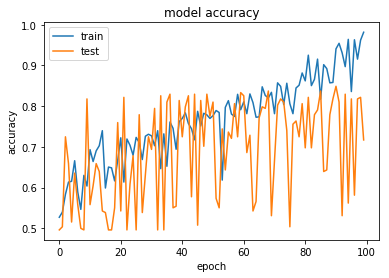

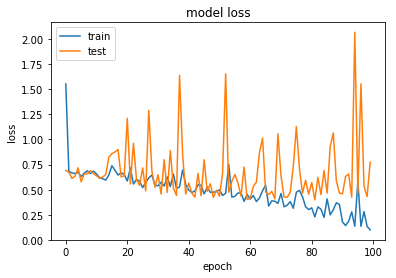

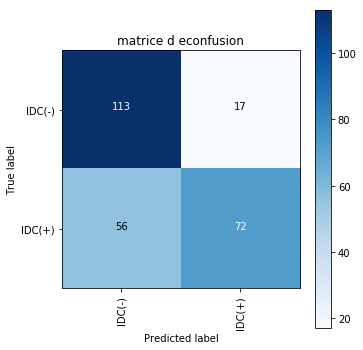

In [2]:
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_100zoom_modelsimple_avec_crop.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

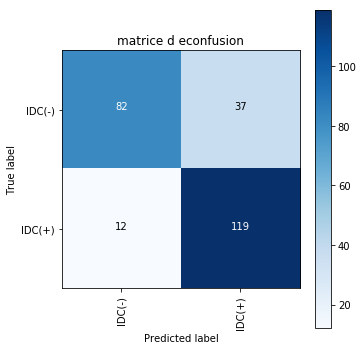

In [3]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_100zoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

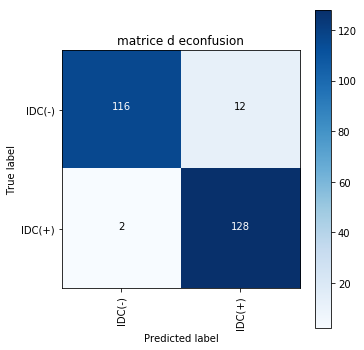

In [4]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_100zoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

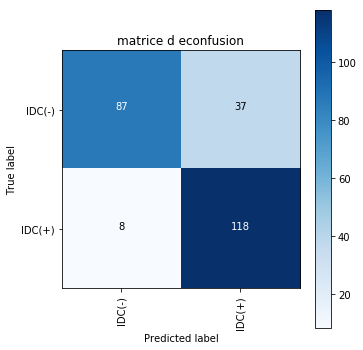

In [5]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_200m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_200m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_100zoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

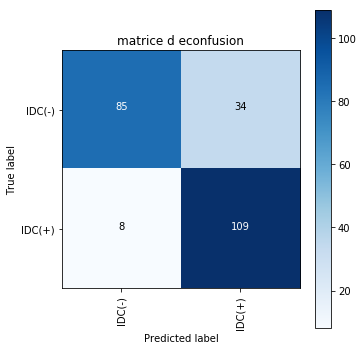

In [7]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_400m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_400m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_100zoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/100
1030/1030 [==============================] - 4s 3ms/step - loss: 1.7894 - acc: 0.6301 - val_loss: 2.0089 - val_acc: 0.4961

Epoch 00001: val_acc improved from -inf to 0.49612, saving model to weights.traint_100zoom_modelcomplex_avec_crop.hdf5
Epoch 2/100
1030/1030 [==============================] - 1s 844us/step - loss: 0.8459 - acc: 0.7388 - val_loss: 1.6872 - val_acc: 0.4806

Epoch 00002: val_acc did not improve from 0.49612
Epoch 3/100
1030/1030 [==============================] - 1s 855us/step - loss: 0.4633 - acc: 0.8097 - val_loss: 2.2068 - val_acc: 0.5116

Epoch 00003: val_acc improved from 0.49612 to 0.51163, saving model to weights.traint_100zoom_modelcomplex_avec_crop.hdf5
Epoch 4/100
1030/1030 [==============================] - 1s 827us/step - loss: 0.4390 - acc: 0.7981 - val_loss: 7.0819 - val_acc: 0.5233

Epoch 00004: val_acc improved from 0.51163 to 0.52326, saving model to weights.traint_100zoom_modelcomplex_avec_

1030/1030 [==============================] - 1s 830us/step - loss: 0.0805 - acc: 0.9680 - val_loss: 2.7601 - val_acc: 0.6318

Epoch 00042: val_acc did not improve from 0.88760
Epoch 43/100
1030/1030 [==============================] - 1s 844us/step - loss: 0.0862 - acc: 0.9670 - val_loss: 0.8816 - val_acc: 0.8023

Epoch 00043: val_acc did not improve from 0.88760
Epoch 44/100
1030/1030 [==============================] - 1s 819us/step - loss: 0.0795 - acc: 0.9709 - val_loss: 4.5946 - val_acc: 0.6473

Epoch 00044: val_acc did not improve from 0.88760
Epoch 45/100
1030/1030 [==============================] - 1s 846us/step - loss: 0.1374 - acc: 0.9544 - val_loss: 1.3819 - val_acc: 0.7984

Epoch 00045: val_acc did not improve from 0.88760
Epoch 46/100
1030/1030 [==============================] - 1s 808us/step - loss: 0.1618 - acc: 0.9398 - val_loss: 1.7088 - val_acc: 0.7597

Epoch 00046: val_acc did not improve from 0.88760
Epoch 47/100
1030/1030 [==============================] - 1s 828us/s


Epoch 00084: val_acc improved from 0.89922 to 0.93023, saving model to weights.traint_100zoom_modelcomplex_avec_crop.hdf5
Epoch 85/100
1030/1030 [==============================] - 1s 885us/step - loss: 0.0355 - acc: 0.9854 - val_loss: 0.7113 - val_acc: 0.8953

Epoch 00085: val_acc did not improve from 0.93023
Epoch 86/100
1030/1030 [==============================] - 1s 889us/step - loss: 0.0504 - acc: 0.9806 - val_loss: 0.3193 - val_acc: 0.9109

Epoch 00086: val_acc did not improve from 0.93023
Epoch 87/100
1030/1030 [==============================] - 1s 873us/step - loss: 0.0216 - acc: 0.9961 - val_loss: 0.2436 - val_acc: 0.9302

Epoch 00087: val_acc did not improve from 0.93023
Epoch 88/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.9951 - val_loss: 0.2104 - val_acc: 0.9612

Epoch 00088: val_acc improved from 0.93023 to 0.96124, saving model to weights.traint_100zoom_modelcomplex_avec_crop.hdf5
Epoch 89/100
1030/1030 [===========================

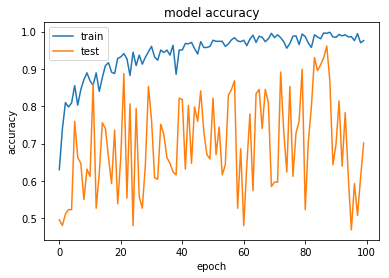

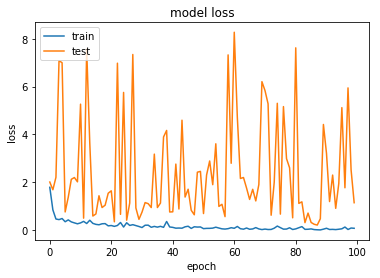

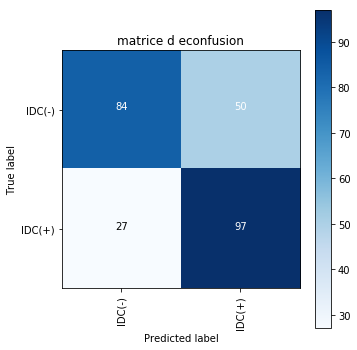

In [8]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_100zoom_modelcomplex_avec_crop.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 64)        36928     
__________

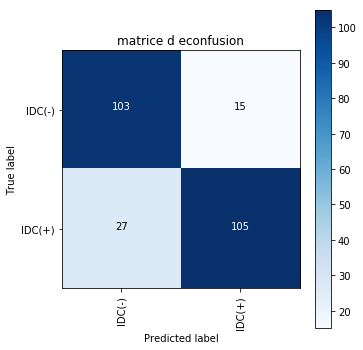

In [9]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_100zoom_modelcomplex_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_23 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 25, 25, 64)        36928     
__________

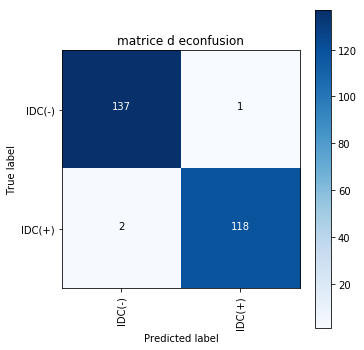

In [10]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_100zoom_modelcomplex_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_28 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 25, 64)        36928     
__________

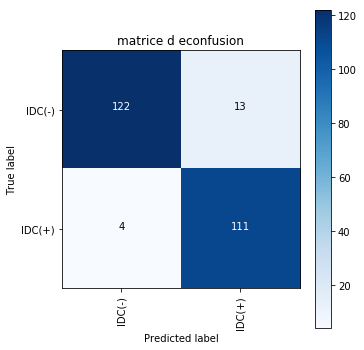

In [11]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_200m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_200m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_100zoom_modelcomplex_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 25, 25, 64)        36928     
__________

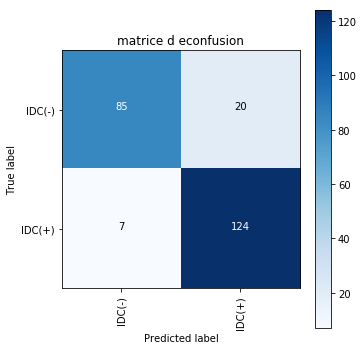

In [12]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_400m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_400m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_100zoom_modelcomplex_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 25, 25, 64)        36928     
__________

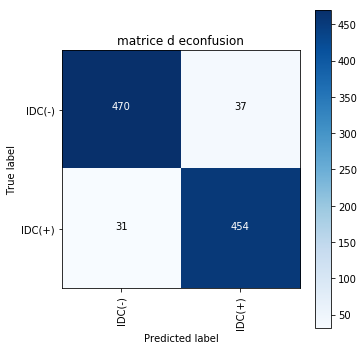

In [6]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoo.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_100zoom_modelcomplex_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/100
1030/1030 [==============================] - 9s 9ms/step - loss: 2.0581 - acc: 0.6592 - val_loss: 8.3069 - val_acc: 0.4845

Epoch 00001: val_acc improved from -inf to 0.48450, saving model to test97.hdf5
Epoch 2/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.8864 - acc: 0.7689 - val_loss: 1.4440 - val_acc: 0.5504

Epoch 00002: val_acc improved from 0.48450 to 0.55039, saving model to test97.hdf5
Epoch 3/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.4007 - acc: 0.8301 - val_loss: 1.0202 - val_acc: 0.6434

Epoch 00003: val_acc improved from 0.55039 to 0.64341, saving model to test97.hdf5
Epoch 4/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3987 - acc: 0.8388 - val_loss: 1.7639 - val_acc: 0.6202

Epoch 00004: val_acc did not improve from 0.64341
Epoch 5/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3552 - acc: 0.8602 - val_loss: 2.1

1030/1030 [==============================] - 1s 1ms/step - loss: 0.1070 - acc: 0.9612 - val_loss: 0.9746 - val_acc: 0.7674

Epoch 00044: val_acc did not improve from 0.86434
Epoch 45/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0883 - acc: 0.9728 - val_loss: 2.3859 - val_acc: 0.5698

Epoch 00045: val_acc did not improve from 0.86434
Epoch 46/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1273 - acc: 0.9563 - val_loss: 0.6299 - val_acc: 0.7946

Epoch 00046: val_acc did not improve from 0.86434
Epoch 47/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1141 - acc: 0.9650 - val_loss: 1.4791 - val_acc: 0.7093

Epoch 00047: val_acc did not improve from 0.86434
Epoch 48/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0509 - acc: 0.9796 - val_loss: 0.9286 - val_acc: 0.7403

Epoch 00048: val_acc did not improve from 0.86434
Epoch 49/100
1030/1030 [==============================] - 1s 1ms/step - loss: 


Epoch 00087: val_acc did not improve from 0.90698
Epoch 88/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0927 - acc: 0.9689 - val_loss: 6.6414 - val_acc: 0.5349

Epoch 00088: val_acc did not improve from 0.90698
Epoch 89/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0317 - acc: 0.9903 - val_loss: 6.4069 - val_acc: 0.5465

Epoch 00089: val_acc did not improve from 0.90698
Epoch 90/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0480 - acc: 0.9806 - val_loss: 4.8142 - val_acc: 0.5891

Epoch 00090: val_acc did not improve from 0.90698
Epoch 91/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0234 - acc: 0.9913 - val_loss: 4.4883 - val_acc: 0.6163

Epoch 00091: val_acc did not improve from 0.90698
Epoch 92/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0343 - acc: 0.9922 - val_loss: 2.2784 - val_acc: 0.7287

Epoch 00092: val_acc did not improve from 0.90698
Epoch 93/100
1

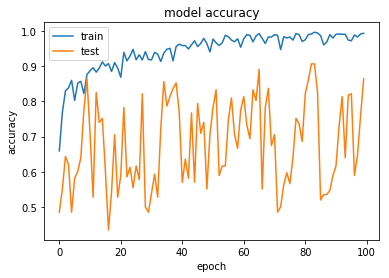

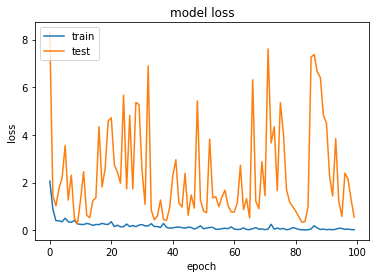

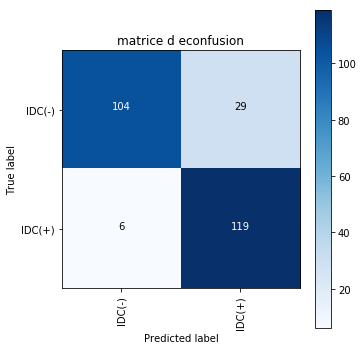

In [2]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="test97.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

In [3]:
X_train.shape

(1030, 50, 50, 3)

In [4]:
X_test.shape

(258, 50, 50, 3)